To open it in colab, follow this [link](https://colab.research.google.com/github/eemlcommunity/PracticalSessions2023/blob/main/diffusion/ddpm.ipynb).

# DDPM

In this tutorial, we'll focus on [Denoising Diffusion Probabilistic Models (DDPMs)](https://arxiv.org/abs/2006.11239).

We'll derive them from the viewpoint of hierarchical latent variable models (inspired by [Variational Diffusion Models](https://arxiv.org/abs/2107.00630) and [Alex Alemi](https://blog.alexalemi.com/diffusion.html)).

The following modular implementation of DDPMs should be a good starting point for implementing other types of diffusion models.

# Installs, imports, and utils

In [1]:
!pip install -q git+https://github.com/deepmind/dm-haiku

  Preparing metadata (setup.py) ... done


In [2]:
from typing import Optional, Callable, Sequence
import functools
import jax
import optax
import dataclasses
import numpy as np
import haiku as hk
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow_datasets as tfds
import tensorflow as tf

In [3]:
def bcast_right(x: jax.Array, ndim: int) -> jax.Array:
    """Util function for broadcasting to the right."""
    if x.ndim > ndim:
      raise ValueError(f'Cannot broadcast a value with {x.ndim} dims to {ndim} dims.')
    elif x.ndim < ndim:
      difference = ndim - x.ndim
      return x.reshape(x.shape + difference * (1,))
    else:
      return x

# Toy 2D data

In [4]:
def create_checkerboard_data(num_datapoints: int, rng_seed: int = 42) -> np.ndarray:
  """Checkerboard dataset."""
  rng = np.random.RandomState(rng_seed)
  x1 = rng.rand(num_datapoints) * 4 - 2
  x2 = rng.rand(num_datapoints) - rng.randint(0, 2, [num_datapoints]) * 2. + np.floor(x1) % 2
  data = np.stack([x1, x2]).T * 2
  data = (data - data.mean(axis=0)) / data.std(axis=0) # normalize
  return data.astype(np.float32)


def dataset_iterator(data: np.ndarray, batch_size: int, rng_seed: int=42):
  """ TF dataset iterator."""
  train_dataset = tf.data.Dataset.from_tensor_slices(tf.constant(data, tf.float32))
  train_dataset = train_dataset.shuffle(buffer_size=10000)
  train_dataset = train_dataset.repeat()
  train_dataset = train_dataset.batch(batch_size, drop_remainder=True)
  train_dataset = tfds.as_numpy(train_dataset)
  return iter(train_dataset)


train_data = create_checkerboard_data(1000000)
train_data_iter = dataset_iterator(train_data, batch_size=2048)


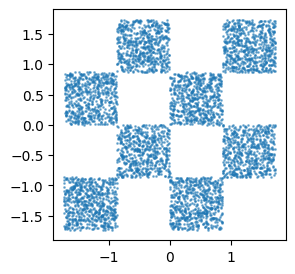

In [5]:
def plot_data(data: np.ndarray):
  plt.figure(figsize=(3, 3))
  plt.scatter(data[:, 0], data[:, 1], s=1, alpha=0.5)
  plt.show()

plot_data(train_data[:5000])



## Forward process

A starting point for diffusion models is to define a forward process that takes samples $x_0$ from our data distribution $q(x_0)$, and creates a sequence of its noisy versions: $x_1$, $x_2$, $\dots$ $x_T$, which we will call latent variables.

<div>
<img src="https://drive.google.com/uc?export=view&id=1MCRHZMdkewgWn93aWrFVWjXLkC7SZE5j" width="500"/>
</div>


We can create this sequence by gradually adding Gaussian noise to the data according to some noise schedule $\beta_1$, $\dots$, $\beta_T$, i.e.

$$q(x_t|x_{t-1}) = N(x_t; \sqrt{1-\beta_t} x_{t-1}, \beta_tI).$$

This Markov chain provides a factorization of the joint distribution:

$$q(x_0, x_1,\dots x_T) = q(x_0)q(x_1|x_0)q(x_2|x_1) \dots q(x_T|x_{T-1})$$

---
For Gaussian conditionals of the form above, we can directly compute $q(x_t|x_0)$:

$$q(x_t|x_0) = N(x_t; \alpha_t x_0, \sigma_t^2 I),$$

where $\alpha_t = \sqrt{\bar \alpha_t}$ with $\bar \alpha_t = \prod_{s=1}^{t}(1 - \beta_s)$, and $\sigma_t^2 = 1- \alpha_t^2$.

Note that by scaling $x_0$ by $ \alpha_t = \sqrt{1- \sigma^2_t}$, we make Var$(x_t)$=Var$(x_0)$.

In diffusion literature, this process is often called variance preserving (VP).


</br>

The class below implements the forward diffusion process from the DDPM paper, where variances $\beta_1, \beta_2,... \beta_T$  increase linearly from $\beta_1$ to $\beta_T$.


In [6]:
class DiscreteDDPMProcess:
  """A Gaussian diffusion process: q(xt|x0) = N(alpha(t)*x0, sigma(t)^2 * I),
  which implies the following transition from x0 to xt:

  xt = alpha(t) x0 + sigma(t) eps, eps ~ N(0, I).

  Diffusion processes differ in how they specify alpha(t) and/or sigma(t).
  Here we follow the DDPM paper.

  """
  def __init__(
      self,
      num_diffusion_timesteps: int = 1000,
      beta_start: float = 0.0001,
      beta_end: float = 0.02,
  ):
    self._num_diffusion_timesteps = num_diffusion_timesteps
    self._beta_start = beta_start
    self._beta_end = beta_end
    self._betas = np.linspace(self._beta_start, self._beta_end, self._num_diffusion_timesteps)

    alphas_bar = self._get_alphas_bar()
    self._alphas = jnp.array(np.sqrt(alphas_bar), jnp.float32)
    self._sigmas = jnp.array(np.sqrt(1 - alphas_bar), jnp.float32)

  @property
  def tmin(self):
    return 1

  @property
  def tmax(self):
    return self._num_diffusion_timesteps

  def _get_alphas_bar(self) -> jax.Array:
    alphas_bar = np.cumprod(1.0 - self._betas)

    # we can add this 1 in front to simplify indexing,
    # and to make alpha[0]=1 and sigma[0]=0.
    # these values at t=0 will be needed later when generating samples
    alphas_bar = np.concatenate(([1.], alphas_bar))

    return  alphas_bar

  def alpha(self, t: jax.Array) -> jax.Array:
    return self._alphas[t]

  def sigma(self, t: jax.Array) -> jax.Array:
    return self._sigmas[t]

  def sample(self, x0: jax.Array, t: jax.Array, eps: jax.Array) -> jax.Array:
    """Draws samples from the forward diffusion process q(xt|x0)."""
    alpha_t = bcast_right(self.alpha(t), x0.ndim)
    sigma_t = bcast_right(self.sigma(t), x0.ndim)
    return alpha_t * x0 + sigma_t * eps

### Visualize DDPM process properties

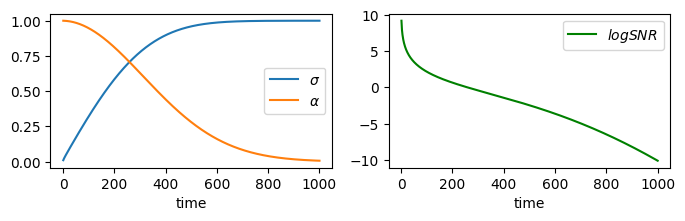

In [7]:
process = DiscreteDDPMProcess(num_diffusion_timesteps=1000)
ts = np.linspace(process.tmin, process.tmax, num=process.tmax, dtype=np.int32)

fig, ax = plt.subplots(1, 2, figsize=(4 * 2, 2))

# plot how alpha and sigma change over time
ax[0].plot(ts, process.sigma(ts), label=r'$\sigma$')
ax[0].plot(ts, process.alpha(ts), label=r'$\alpha$')
ax[0].set_xlabel('time')
ax[0].legend()

# It is often helpful to reason in terms of signal-to-noise ratio:
# SNR = alpha(t)^2 / sigma(t)^2 or more conveniently, its logarithm.
# High SNR = little noise, low SNR = a lot of noise.
lambda_ = [2. * np.log(process.alpha(t) / process.sigma(t)) for t in ts]
ax[1].plot(ts, lambda_, c='g', label=r'$log SNR$')
ax[1].set_xlabel('time')
ax[1].legend()

plt.show()

In [8]:
mnist = pd.read_csv('/content/sample_data/mnist_train_small.csv', header=None).to_numpy()
img = mnist[0, 1:].reshape((28, 28))
img = 2 * img / 255. - 1. # rescale from [0,255] to [-1,1]

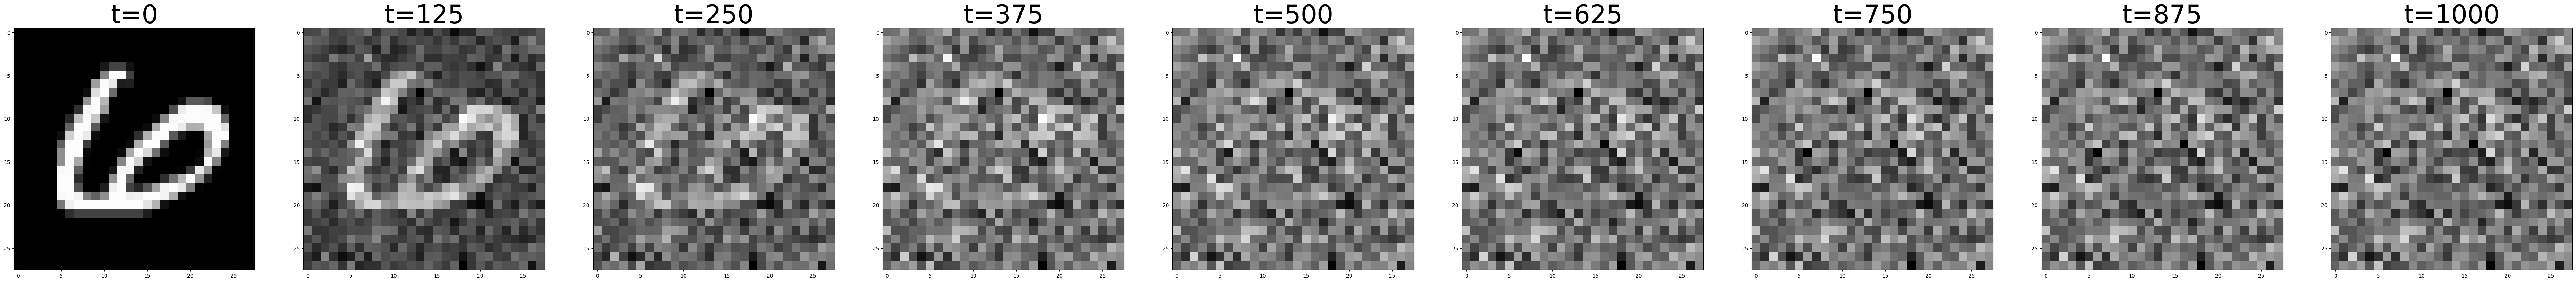

In [9]:
timesteps = np.linspace(0, 1000, 9, dtype=np.int32)
eps = np.random.normal(size=img.shape)

fig, ax = plt.subplots(1, len(timesteps) , figsize=(10 * len(timesteps), 10))

for i, t in enumerate(timesteps):
  img_t = process.sample(img, t, eps)
  ax[i].imshow(img_t, cmap='gray')
  ax[i].set_title(f't={t}', fontsize=50)

## Reverse process

So far, we have defined a process that takes us from clean data $x_0$ to noise $x_T$.

What we are after is a generative model that takes us in the reverse direction.

<div>
<img src="https://drive.google.com/uc?export=view&id=1TT8CKNnu5ptf4c5j_I5CSuLjdyUL-wle" width="500"/>
</div>


The reverse process defines the following joint distribution:

$$p_{\theta}(x_0,x_1,\dots,x_T) = p_{\theta}(x_T)p_{\theta}(x_{T-1}|x_T)\dots p_{\theta}(x_1|x_2)p_{\theta}(x_0|x_1)$$


If we try to minimize the KL divergence between the forward and reverse processes, we obtain a bound on the marginal KL divergence between the true data distribution $q(x_0)$ and the marginal distribution of our generative model $p_{\theta}(x_0)$:

$$\mathbb E_q \left[\log \frac{q(x_0,x_1,\dots x_T)}{p_{\theta}(x_0, x_1\dots x_T)}\right] \ge \mathbb E_q \left[\log \frac{q(x_0)}{p_{\theta}(x_0)}\right] \ge 0$$

Thus, by learning to make the two joint processes look alike, as a consequence, we are also learning a good generative model.

In practice, to deal with the KL divergence between the forward and reverse processes, we need to do a couple of math tricks.

---

**Trick 1:** rewrite the forward process as a bunch of conditional reverse steps.

Instead of factorizing the joint distribution of the forward process as a sequence of conditional Gaussian steps, i.e.

$$q(x_0, x_1,\dots x_T) = q(x_0)q(x_1|x_0)q(x_2|x_1) \dots q(x_T|x_{T-1})$$

we will write it as bunch of conditional reverse steps:

$$q(x_0, x_1, \dots x_T) = q(x_1, \dots x_T|x_0) q(x_0) = q(x_1| x_2, \dots x_T, x_0)q(x_2 |x_1, \dots x_T, x_0) \dots q(x_T |x_0) q(x_0) = q(x_1|x_2, x_0) q(x_2 |x_3, x_0) \dots q(x_{T-1}|x_{T}, x_0) q(x_T|x_0) q(x_0)$$

<div>
<img src="https://drive.google.com/uc?export=view&id=1_f5al8x39q5-4yyJzceqYkFRpg6MYoXl" width="500"/>
</div>

Each $q(x_{t-1}|x_{t}, x_0)$ is a Gaussian:

$$q(x_{t-1}|x_{t}, x_0) = N(x_{t-1}; \tilde{\mu_t}(x_t, x_0), \tilde{\sigma_t}^2 I),$$
where
\begin{equation}
\tilde{\mu_t}(x_t, x_0) = \frac{\alpha_t \sigma^2_{t-1}}{\alpha_{t-1}\sigma^2_t} x_t + \frac{\alpha_{t-1}}{\sigma^2_t} \beta_t x_0 \tag{*}
\end{equation}

$$\tilde{\sigma_t} = \frac{\sigma^2_{t-1}}{\sigma^2_t}\beta_t$$

Remember that $\beta_t$ is the variance of $q(x_t|x_{t-1})$ and can be computed as $1 - \frac{\alpha_t^2}{\alpha_{t-1}^2}$.

---

**Trick 2:** parameterize the reverse process step to have the same functional form as $q(x_{t-1}|x_{t}, x_0)$.

This means we would model $p_{\theta}(x_{t-1}|x_{t}, \widehat{x}_0)$ as the Gaussian distribution above, i.e.

$$p_{\theta}(x_{t-1}|x_{t}, \widehat{x}_0) = N(x_{t-1}; \tilde{\mu_t}(x_t, \widehat x_0), \tilde{\sigma_t}^2 I). $$

Note that instead of $x_0$ we used $\widehat{x}_0$ -- a prediction of what $x_0$ could be. This is because the generative model should not have access to the original $x_0$.

To predict $\widehat x_0$ we use a neural network. Explicitly, we can write $\widehat{x_0}(x_t, t; \theta)$ to denote that this is an output of a neural net with parameters $\theta$ that takes a noised example $x_t$ and $t$ as inputs. For this reason, it is often called a *denoiser* since it takes a noisy input $x_t$ at time $t$, and tries to predict a clean $x_0$.

Alternatively, instead of predicting $x_0$, we can make our neural network to predict the noise $\epsilon$ that was added to $x_0$. Remember that given $x_t$ we can always compute one from another using the following equation:

\begin{equation}
\widehat{x_0}(x_t, t; \theta) = \frac{1}{\alpha_t}(x_t  - \sigma_t \cdot \widehat\epsilon(x_t, t; \theta))
\end{equation}

Substituting the above prediction of $x_0$ into Eq.(*), we get the following mean for $p_{\theta}(x_{t-1}|x_{t}, \widehat{x}_0)$:


$$ \tilde{\mu_t}(x_t, \widehat x_0) = \frac{\alpha_{t-1}}{\alpha_{t}} \left( x_t - \frac{\beta_t}{\sigma_t} \widehat\epsilon(x_t, t; \theta) \right)$$


## Network

Let's start implementing the network that predicts $\widehat \epsilon(x_t, t; \theta)$.

In [10]:
class ResidualMLP(hk.Module):
  """MLP with residual connections."""

  def __init__(
      self,
      n_blocks: int,
      n_hidden: int,
      n_out: int,
      activation: str,
      name: Optional[str] = None
  ):
    super().__init__(name=name)
    self._n_blocks = n_blocks
    self._n_hidden = n_hidden
    self._n_out = n_out
    self._activation = getattr(jax.nn, activation)


  def __call__(self, xt: jax.Array, time: jax.Array) -> jax.Array:

    x = hk.Linear(output_size=self._n_hidden)(xt)

    for _ in range(self._n_blocks):
      h = self._activation(x)
      h = hk.Linear(output_size = self._n_hidden)(h)
      h += hk.Linear(output_size = self._n_hidden)(time)
      h = self._activation(h)
      h = hk.Linear(output_size = self._n_hidden)(h)
      x += h

    outputs = hk.Linear(output_size=self._n_out, w_init=hk.initializers.Constant(0.))(x)

    return outputs

### Time embeddings

As we can see above, the denoiser network needs to get timestep $t$ as an input.

However, feeding integers $t=1, 2, ... T$ into the network will not work.

[Transformers](https://arxiv.org/abs/1706.03762), when faced with the same problem, proposed to embed timesteps into $d$-dimensional vectors of sinusoids:

$$e = [\; \sin(w_1 t) \; \; \cos(w_1 t) \; ... \; \sin(w_{d/2} t) \; \; \cos(w_{d/2} t) \;]$$

with $w_i = 1/ 10000^{\frac{2i}{d}}$.

Here is nice blogpost with more intuition: https://kazemnejad.com/blog/transformer_architecture_positional_encoding/


In [11]:
class SinusoidalTimeEmbedding(hk.Module):
  """Time (positional) embedding as in Transformers."""

  def __init__(self, num_features: int, name: Optional[str] = None):
    super().__init__(name=name)
    self._num_features = num_features

  def __call__(self, inputs: jax.Array) -> jax.Array:
    assert len(inputs.shape) == 1
    half_dim = self._num_features // 2
    e = np.log(10000) / (half_dim - 1)
    embedding = jnp.exp(-e * jnp.arange(half_dim))
    embedding = inputs[:, None] * embedding
    embedding = jnp.concatenate([jnp.cos(embedding), jnp.sin(embedding)], axis=-1)
    if self._num_features % 2 == 1:
      embedding = jnp.pad(embedding, ((0, 0), (0, 1)))
    return embedding

Now we need to put the two modules together:

In [12]:
@dataclasses.dataclass
class NetConfig:
  resnet_n_blocks: int = 2
  resnet_n_hidden: int = 256
  resnet_n_out: int = 2
  activation: str = 'elu'
  time_embedding_dim: int = 256


class Net(hk.Module):
  """Combines MLP and time embeddings."""
  def __init__(self, net_config: NetConfig, name: Optional[str] = None):
    super().__init__(name=name)

    self._time_encoder = SinusoidalTimeEmbedding(net_config.time_embedding_dim)
    self._predictor = ResidualMLP(n_blocks=net_config.resnet_n_blocks,
                                  n_hidden = net_config.resnet_n_hidden,
                                  n_out = net_config.resnet_n_out,
                                  activation = net_config.activation)

  def __call__(self, noisy_data: jax.Array, time: jax.Array) -> jax.Array:
    time_embedding = self._time_encoder(time)
    outputs = self._predictor(noisy_data, time_embedding)
    return outputs

## Objective function

Remember that we set the goal of minimizing the KL divergence between the forward and reverse processes, which we can rewrite in terms of conditional distributions.

\begin{align}
\mathbb E_q \left[\log \frac{q(x_0,x_1,\dots x_T)}{p_\theta(x_0, x_1\dots x_T)}\right]  &= \mathbb E_q \left[\log q(x_0)  - \log p_\theta(x_0|x_1) + \log \frac{q(x_T|x)}{p_\theta(x_T)} + \sum_{i=1}^{T}\log {\frac{q(x_i|x_{i+1}, x_0)}{p_\theta(x_i|x_{i+1}, \widehat x_0)}}\right] \\
\end{align}

Parts of this objective are:

- data entropy $\mathbb E_q [\log q(x_0)]$ is a constant
- reconstruction loss $-\mathbb E_q [\log {p_\theta}(x_0|x_1)]$
- prior loss $\mathbb E_q [\log \frac{q(x_T|x)}{p_\theta(x_T)}]\approx 0$
- the last term is the diffusion loss $L_T$ -- the important bit


Luckily, KL divergences between Gaussian distributions can be computed analytically, so the diffusion loss $L_T$ simplifies to

$$L_T = \mathbb E_q \left[\frac{1}{2}\sum_{t=1}^{T} w_t ||\epsilon -  \widehat \epsilon(x_t,t; \theta) ||^2 \right],$$
where $w_t$ are the weights that depend on the noise schedule of the forward process, i.e. $\sigma_t$.

In DDPM, these weights are set to 1, which was motivated by empirical results.
Thus, we are left with

$$L_T = \mathbb E_q \left[\frac{1}{2}\sum_{t=1}^{T} ||\epsilon -  \widehat \epsilon(x_t,t; \theta) ||^2 \right]$$

The Monte-Carlo estimate (without $\frac{T}{2}$ multiplicative factor) of this loss would be:

$$L_{simple}(\theta) = \mathbb E_{x_0 \sim q(x_0), \;\epsilon \sim N(0, I) ,\;t \sim U(1,T)} ||\epsilon -  \widehat \epsilon(x_t,t; \theta) ||^2, $$

and this will be a training objective for our neural network.

## Time sampler
To compute our loss function, for each example, we need to sample a random timestep. In this trivial case of uniform sampling between step 1 and T, it might be an overkill to implement it as a separate class. It would be more helpful if you're going to explore more exotic diffusion models.

In [13]:
class UniformDiscreteTimeSampler:

  def __init__(self, tmin: int, tmax: int):
    self._tmin = tmin
    self._tmax = tmax

  def sample(self, key: jax.Array, shape: Sequence[int]) -> jax.Array:
    return jax.random.randint(key, shape, minval=self._tmin, maxval=self._tmax)

## Full DDPM model

In [14]:
class DiffusionModel:
  """Diffusion model."""

  def __init__(self, diffusion_process: DiscreteDDPMProcess,
               time_sampler: UniformDiscreteTimeSampler,
               net_config: NetConfig,
               data_shape: tuple[int, ...]):
    super().__init__()

    self._process = diffusion_process
    self._time_sampler = time_sampler
    self._net_config = net_config
    self._data_shape = data_shape

    # don't worry about this haiku stuff.
    # the important bit is to get two pure functions:
    # net_init(rng_key, noisy_data, time) and net_apply(params, noisy_data, time)
    # so that afterwards we can use only jax
    def net_fwd(x, t):
      net = Net(net_config)
      return net(x, t)

    self.net_init, self.net_apply = hk.without_apply_rng(hk.transform(net_fwd))

  def init(self, rng_key: jax.Array, x0: jax.Array) -> hk.Params:
    time = jnp.zeros((x0.shape[0],))
    params = self.net_init(rng_key, x0, time)
    return params


  @functools.partial(jax.jit, static_argnums=(0,))
  def loss(self, params: hk.Params, rng_key: jax.Array, x0: jax.Array) -> jax.Array:
    """Computes MSE between the true noise and predicted noise,
    i.e. the goal of the network is to correctly predict eps from a noisy observation
    xt = alpha(t) * x0 + sigma(t)**2 * eps"""

    subkey_eps, subkey_t = jax.random.split(rng_key)

    t = self._time_sampler.sample(key=subkey_t, shape=(x0.shape[0],)) # sample time

    eps = jax.random.normal(key=subkey_eps, shape=x0.shape) # sample noise

    xt = self._process.sample(x0, t, eps) # corrupt the data

    net_outputs = self.net_apply(params, xt, t) # get net outputs

    loss = jnp.mean((net_outputs - eps) ** 2) # compute MSE loss between predicted and true noise

    return loss


  @functools.partial(jax.jit, static_argnums=(0,))
  def loss_per_timesteps(self, params: hk.Params, x0: jax.Array, eps: jax.Array, timesteps: jax.Array) -> jax.Array:
    """ Computes loss values at given timesteps."""
    losses = []
    for t in timesteps:
      t = t * jnp.ones((x0.shape[0],), dtype=jnp.int32)
      xt = self._process.sample(x0, t, eps)
      net_outputs = self.net_apply(params, xt, t)
      loss = jnp.mean((net_outputs - eps) ** 2)
      losses.append(loss)
    return jnp.asarray(losses)



  @functools.partial(jax.jit, static_argnums=(0,))
  def _reverse_process_step(
      self,
      params: hk.Params,
      rng_key: jax.Array,
      xt: jax.Array,
      t: int,
  ) -> tuple[jax.Array, jax.Array]:
    """Computes parameters of a Gaussian p(x_{t-1}| x_t, x0_pred)."""
    t = t * jnp.ones((xt.shape[0],), dtype=jnp.int32)

    eps_pred = self.net_apply(params, xt, t) # predict epsilon from x_t

    sqrt_a_t = self._process.alpha(t) / self._process.alpha(t-1)
    inv_sqrt_a_t = bcast_right(1.0 / sqrt_a_t, xt.ndim)

    beta_t = 1. - sqrt_a_t **2
    beta_t = bcast_right(beta_t, xt.ndim)

    inv_sigma_t = bcast_right(1.0 / self._process.sigma(t), xt.ndim)

    mean = inv_sqrt_a_t * (xt - beta_t * inv_sigma_t * eps_pred)

    # DDPM instructs to use either the variance of the forward process
    # or the variance of q(x_{t-1}|x_t, x_0). Former is easier.
    std = jnp.sqrt(beta_t)

    z = jax.random.normal(key=rng_key, shape=xt.shape)

    return mean + std * z


  def sample(self, params: hk.Params, rng_key: jax.Array, n_samples: int) -> jax.Array:
    """To generate samples from DDPM, we follow the reverse process.
    At each step, we sample x_{t-1} from p(x_{t-1}| x_t, x0_pred) until we get to x_0."""
    subkeys = jax.random.split(rng_key, num=self._process.tmax + 1)

    x = jax.random.normal(key=subkeys[0], shape=(n_samples,) + self._data_shape)

    for t in range(self._process.tmax, 0, -1):
      x = self._reverse_process_step(params, subkeys[t], x, t)

    return x


# Training

In [15]:
# create the model
diffusion_process = DiscreteDDPMProcess(num_diffusion_timesteps=1000)
time_sampler = UniformDiscreteTimeSampler(diffusion_process.tmin, diffusion_process.tmax)
model = DiffusionModel(diffusion_process, time_sampler, net_config=NetConfig(), data_shape=(2,))

# initialize model parameters
x0_init = next(train_data_iter)
rng_key = jax.random.PRNGKey(42)
params = model.init(rng_key, x0_init)
num_parameters = hk.data_structures.tree_size(params)
print(f'Num. params: {num_parameters:,}')

Num. params: 396,034


In [16]:
#@title Optimizer
training_steps = 50_000 # @param

lr_schedule = optax.warmup_cosine_decay_schedule(
                init_value=0.,
                peak_value=3e-4,
                warmup_steps=1000,
                decay_steps=training_steps,
                end_value=1e-5,
            )

optimizer = optax.chain(
  optax.clip_by_global_norm(max_norm=1),
  optax.scale_by_adam(),
  optax.scale_by_schedule(lr_schedule),
  optax.scale(-1.0))

opt_state = optimizer.init(params)

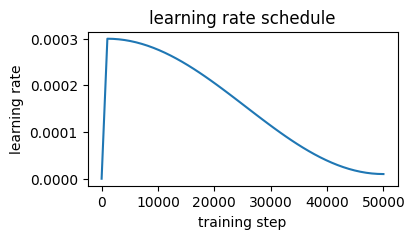

In [17]:
# plot the learning rate schedule
steps = np.linspace(0, training_steps, dtype=np.int32)
plt.figure(figsize=(4, 2))
plt.plot(steps, lr_schedule(steps))
plt.title('learning rate schedule')
plt.xlabel('training step')
plt.ylabel('learning rate')
plt.show()

In [18]:
#@title Update function

@jax.jit
def update(params: hk.Params, opt_state: optax.OptState, rng_key: jax.Array, x0_batch: jax.Array):
  rng_key, next_rng_key = jax.random.split(rng_key)

  # evaluate loss for a given batch and params, and compute the gradients
  loss_value, gradients = jax.value_and_grad(model.loss)(params, rng_key, x0_batch)

  # compute Adam updates and new optimizer state
  updates, new_opt_state = optimizer.update(gradients, opt_state)

  # update params
  new_params = optax.apply_updates(params, updates)

  return loss_value, (new_params, new_opt_state, next_rng_key)

In [19]:
#@title Validation dataset

valid_data = create_checkerboard_data(10000, rng_seed=24) # generate some validation data

# fix the noise so that the validation loss is deterministic
rng_key, subkey = jax.random.split(rng_key)
valid_eps = jax.random.normal(key=subkey, shape=valid_data.shape)

# we will evaluate the loss on a fixed set of timesteps
valid_timesteps = jnp.linspace(diffusion_process.tmin, diffusion_process.tmax, 25, dtype=np.int32)

step: 0, validation loss: 0.98836


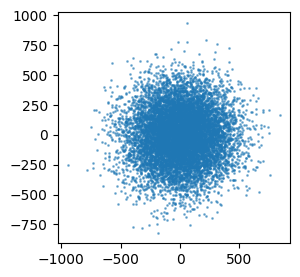

step: 1000, validation loss: 0.26910
step: 2000, validation loss: 0.26435
step: 3000, validation loss: 0.25959
step: 4000, validation loss: 0.25893
step: 5000, validation loss: 0.25822
step: 6000, validation loss: 0.25703
step: 7000, validation loss: 0.25744
step: 8000, validation loss: 0.25729
step: 9000, validation loss: 0.25783
step: 10000, validation loss: 0.25661


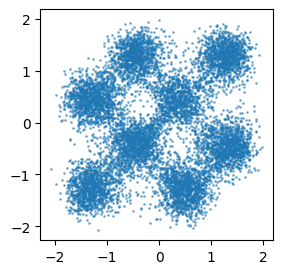

step: 11000, validation loss: 0.25643
step: 12000, validation loss: 0.25709
step: 13000, validation loss: 0.25645
step: 14000, validation loss: 0.25629
step: 15000, validation loss: 0.25610
step: 16000, validation loss: 0.25579
step: 17000, validation loss: 0.25592
step: 18000, validation loss: 0.25514
step: 19000, validation loss: 0.25619
step: 20000, validation loss: 0.25517


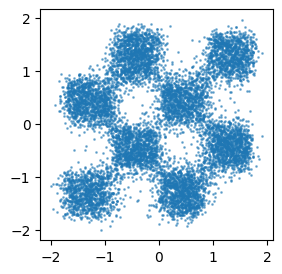

step: 21000, validation loss: 0.25485
step: 22000, validation loss: 0.25494
step: 23000, validation loss: 0.25469
step: 24000, validation loss: 0.25485
step: 25000, validation loss: 0.25469
step: 26000, validation loss: 0.25453
step: 27000, validation loss: 0.25434
step: 28000, validation loss: 0.25435
step: 29000, validation loss: 0.25441
step: 30000, validation loss: 0.25431


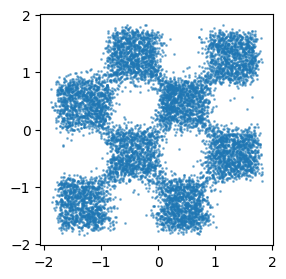

step: 31000, validation loss: 0.25417
step: 32000, validation loss: 0.25431
step: 33000, validation loss: 0.25401
step: 34000, validation loss: 0.25393
step: 35000, validation loss: 0.25386
step: 36000, validation loss: 0.25380
step: 37000, validation loss: 0.25378
step: 38000, validation loss: 0.25383
step: 39000, validation loss: 0.25359
step: 40000, validation loss: 0.25360


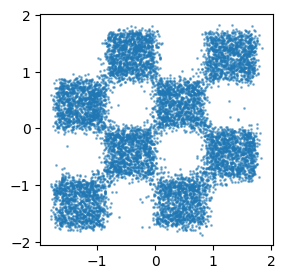

step: 41000, validation loss: 0.25370
step: 42000, validation loss: 0.25361
step: 43000, validation loss: 0.25361
step: 44000, validation loss: 0.25367
step: 45000, validation loss: 0.25363
step: 46000, validation loss: 0.25345
step: 47000, validation loss: 0.25339
step: 48000, validation loss: 0.25351
step: 49000, validation loss: 0.25345


In [20]:
#@title Training loop

for step in range(training_steps):
  x0_batch = next(train_data_iter)
  loss_value, (params, opt_state, rng_key) = update(params, opt_state, rng_key, x0_batch)

  if step % 1000 == 0:
    mean_loss_per_timesteps = np.mean(model.loss_per_timesteps(params, valid_data, valid_eps, valid_timesteps))
    print(f'step: {step}, validation loss: {mean_loss_per_timesteps:.5f}')

  if step % 10000 == 0:
    samples = model.sample(params, rng_key, 10000)
    plot_data(samples)

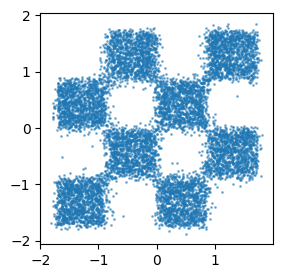

In [21]:
#@title Samples after training
samples = model.sample(params, rng_key, 10000)
plot_data(samples)

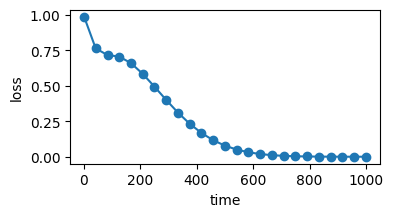

In [22]:
#@title Visualize loss-per-timestep
loss_per_timestep = model.loss_per_timesteps(params, valid_data, valid_eps, valid_timesteps)
plt.figure(figsize=(4, 2))
plt.plot(valid_timesteps, loss_per_timestep)
plt.scatter(valid_timesteps, loss_per_timestep)
plt.xlabel('time')
plt.ylabel('loss')
plt.show()

# Final remarks

A few tips on how to extend this code to image data:

- replace `ResildulMLP` with a [U-Net](https://arxiv.org/abs/1505.04597) with or without attention blocks. You might want some inspiration from the original [DDPM implementation](https://github.com/hojonathanho/diffusion)

- to get better quality samples, use [classifier-free guidance](https://arxiv.org/abs/2207.12598)

- remember to pre-process your input images. Normally, they are rescaled to $[-1; 1]$.

- consider using alternative samplers, e.g. [DDIM](https://arxiv.org/abs/2010.02502), to make sampling faster.  

- during sampling, it becomes important to clip your predictions $\widehat x_0(x_t, t; \theta)$ to the right range.


</br>

If you have any questions, please feel free to email me: irene.korshunova@gmail.com
